In [1]:
import torch as torch
import torch.nn as nn
from typing import Optional
from math import floor, log2, sqrt
import torch.nn.functional as F

In [2]:
class GeneralMoE(nn.Module):
    def __init__(self, gate: nn.Module, experts: nn.Module):
        super().__init__()
        self.gate, self.experts = gate, experts
    
    def forward(self, x: torch.Tensor):
        probs, indices = self.gate(x)
        return self.experts(x, probs, indices)

In [3]:
class SoftMergingExperts(nn.Module): 
    def __init__(self, n_exp, in_dim, out_dim, h_dim, save_probs=False):
        super().__init__()
        self.save_probs, self.n_exp = save_probs, n_exp

        def uniform(shape, scale):
            return nn.Parameter(torch.empty(shape).uniform_(-scale, scale))
        self.w1 = uniform((self.n_exp, h_dim, in_dim), scale=1/sqrt(in_dim))
        self.w2 = uniform((self.n_exp, out_dim, h_dim), scale=1/sqrt(h_dim))
        self.act = nn.ReLU()

    def forward(self, x: torch.Tensor, probs: torch.Tensor = None, indices: torch.Tensor = None):
        """At least one of `probs` or `indices` should be not None."""
        bs = x.shape[0]
        if self.training:
            # construct a merged expert in the first layer
            w1 = torch.einsum(
                'bkxy,bk->bxy', self.w1.repeat(bs, 1, 1, 1), probs)
            x = x[:, None].bmm(w1.mT).squeeze(1)

            # similar for the next layer
            w2 = torch.einsum(
                'bkxy,bk->bxy', self.w2.repeat(bs, 1, 1, 1), probs)
            x = x[:, None].bmm(w2.mT).squeeze(1)
            if self.save_probs: self.probs = probs.detach()
        else:
            w1 = self.w1[indices]
            x = x[:, None].bmm(w1.mT).squeeze(1)

            w2 = self.w2[indices]
            x = x[:, None].bmm(w2.mT).squeeze(1)
            if self.save_probs: self.probs = F.one_hot(indices.detach(), self.n_exp)
        return x

In [41]:
class GateMoE(nn.Module):
    def __init__(self, in_dim, n_exp, top_k=1):
        super().__init__()
        self.n_exp, self.top_k = n_exp, top_k
        self.gate = nn.Linear(in_dim, n_exp, bias=False)

    def forward(self, x):
        probs = torch.softmax(self.gate(x), dim=-1)
        indices = torch.topk(probs, self.top_k, dim=-1)[1].squeeze(-1)
        return probs, indices
    
class GateFFF(nn.Module):
    def __init__(self, in_dim, depth, tree_act=nn.Softplus()):
        super().__init__()
        self.tree_act, self.depth = tree_act, depth
        self.n = 2**depth
        def uniform(shape, scale):
            return nn.Parameter(torch.empty(shape).uniform_(-scale, scale))
        self.nodes = uniform((self.n-1, in_dim), scale=1/sqrt(in_dim))
        self.t = self.init_t_()
        
    def init_t_(self):
        tree, res = torch.eye(self.n), []
        for _ in range(self.depth): 
            res.append(tree)
            tree = tree.view(self.n, -1, 2).sum(-1)
        return nn.Parameter(torch.cat(list(reversed(res)),dim=1), False)

    def forward(self, x):
        bs = x.shape[0]
        probs, indices = None, None
        if self.training:
            # get probs for each node
            x = x.matmul(self.nodes.T)
            probs = self.tree_act(torch.stack([x, -x],dim=2).view(bs,-1)).matmul(self.t.T)
            probs = torch.softmax(probs, dim=-1)
        else:
            # select node with highest prob at each level
            indices = torch.zeros(bs, dtype=torch.long, device=x.device)
            for _ in range(self.depth):
                indices = indices*2 + 1 + (torch.einsum("bi,bi->b", x, self.nodes[indices])<0).long()
            # map to leaves that range from 0
            indices = indices - self.n + 1
        return probs, indices

In [5]:
class SoftMergingFFF(nn.Module):
    def __init__(self, in_dim, out_dim, h_dim, depth, tree_act=nn.Softplus(), save_probs=False):
        super().__init__()
        self.save_probs, self.tree_act, self.depth = save_probs, tree_act, depth
        self.n = 2**depth
        def uniform(shape, scale): 
            return nn.Parameter(torch.empty(shape).uniform_(-scale,scale))
        self.nodes = uniform((self.n-1, in_dim), scale=1/sqrt(in_dim))
        self.w1 = uniform((self.n, h_dim, in_dim), scale=1/sqrt(in_dim))
        self.w2 = uniform((self.n, out_dim, h_dim), scale=1/sqrt(h_dim))
        self.act = nn.ReLU()
        self.t = self.init_t_()

    def init_t_(self):
        tree, res = torch.eye(self.n), []
        for _ in range(self.depth): 
            res.append(tree)
            tree = tree.view(self.n, -1, 2).sum(-1)
        return nn.Parameter(torch.cat(list(reversed(res)),dim=1), False)

    def forward(self, x: torch.Tensor):
        bs = x.shape[0]
        if self.training:
            # get probs for each node
            z = x.matmul(self.nodes.T)
            probs = self.tree_act(torch.stack([z, -z],dim=2).view(bs,-1)).matmul(self.t.T)
            probs = torch.softmax(probs, dim=-1)
            
            # save probs for debugging and visualization
            if self.save_probs: self.probs = probs
            
            # construct a merged expert in the first layer
            w1 = torch.einsum('bkxy,bk->bxy', self.w1.repeat(bs,1,1,1), probs)
            x = x[:,None].bmm(w1.mT).squeeze(1)
            
            x = self.act(x)
            
            # similar for the next layer
            w2 = torch.einsum('bkxy,bk->bxy', self.w2.repeat(bs,1,1,1), probs)
            x = x[:,None].bmm(w2.mT).squeeze(1)
        else:
            # select node with highest prob at each level
            indices = torch.zeros(bs, dtype=torch.long, device=x.device)
            for _ in range(self.depth):
                indices = indices*2 + 1 + (torch.einsum("bi,bi->b", x, self.nodes[indices])<0).long()
            # map to leaves that range from 0
            indices = indices - self.n + 1
            w1 = self.w1[indices]
            x = x[:,None].bmm(w1.mT).squeeze(1)
            x = self.act(x)
            
            w2 = self.w2[indices]
            x = x[:,None].bmm(w2.mT).squeeze(1)
        return x

epoch,train_loss,valid_loss,accuracy,time
0,0.604958,1.701688,0.695000,00:21
1,0.302282,0.750761,0.833300,00:16
2,0.216696,0.524621,0.870100,00:18
3,0.164715,0.558846,0.875000,00:17
4,0.133393,0.552776,0.877200,00:17


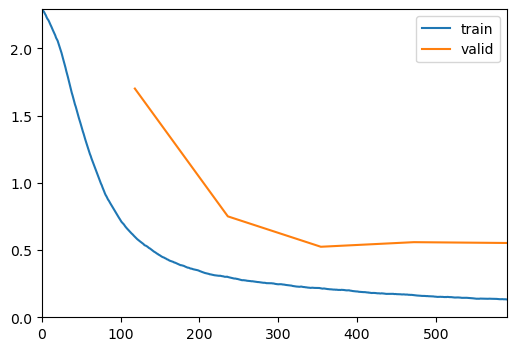

In [31]:
from fastai.callback.wandb import *
from FastFF.utils import *
from fastai.vision.all import *

bs = 512
in_dim=28*28
out_dim=10
h_dim=4
depth=3

model = GeneralMoE(GateFFF(in_dim, depth), 
                   SoftMergingExperts(2**depth, in_dim, out_dim, h_dim, save_probs=True))
model = torch.compile(model)
cbs = [ProbsDistrCB(module=model.experts), GetGradCB([model.gate.nodes]), ShowGraphCallback()]
dls = get_mnist_dls(bs)
Learner(dls, model, loss_func=F.cross_entropy, metrics=accuracy, cbs=cbs).fit_one_cycle(5, lr_max=1e-2)

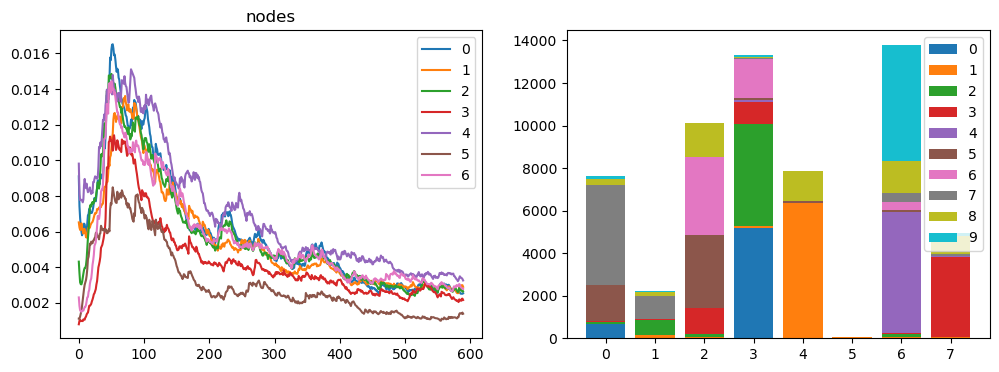

In [32]:
def summary():
    axes = subplots(ncols=2, figsize=(12,4))[1]
    axes[0].title.set_text('nodes')
    cbs[1].show(model.gate.nodes, lambda x: x.abs().mean(-1), ax=axes[0])
    cbs[0].show(-1, ax=axes[1])
summary()

epoch,train_loss,valid_loss,accuracy,time
0,0.615206,1.055282,0.722800,00:24
1,0.342229,1.495477,0.673600,00:17
2,0.247750,0.986513,0.744700,00:17
3,0.202701,0.911428,0.752400,00:18
4,0.169319,0.858024,0.767900,00:19


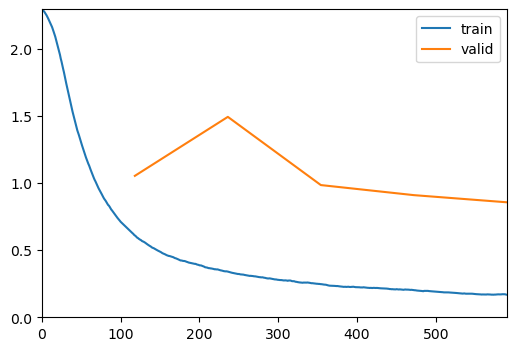

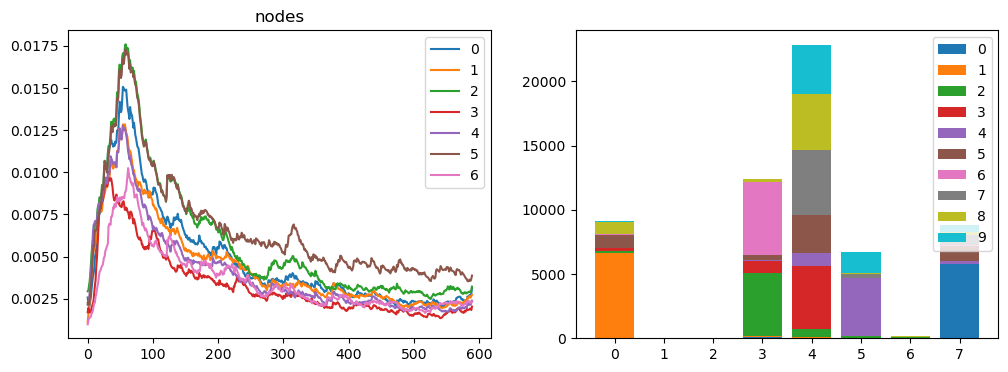

In [29]:
model = GeneralMoE(GateFFF(in_dim, depth, tree_act=nn.ReLU()), 
                   SoftMergingExperts(2**depth, in_dim, out_dim, h_dim, save_probs=True))
model = torch.compile(model)
cbs = [ProbsDistrCB(module=model.experts), GetGradCB([model.gate.nodes]), ShowGraphCallback()]
Learner(dls, model, loss_func=F.cross_entropy, metrics=accuracy, cbs=cbs).fit_one_cycle(5, lr_max=1e-2)
summary()

epoch,train_loss,valid_loss,accuracy,time
0,0.612143,0.550316,0.851500,00:30
1,0.313795,0.529659,0.840500,00:17
2,0.244149,0.305996,0.915500,00:17
3,0.207085,0.355595,0.899500,00:16
4,0.175706,0.304913,0.914400,00:22


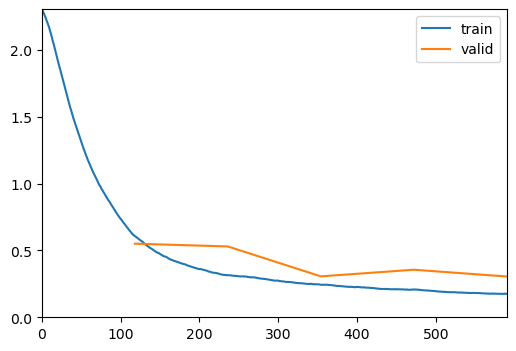

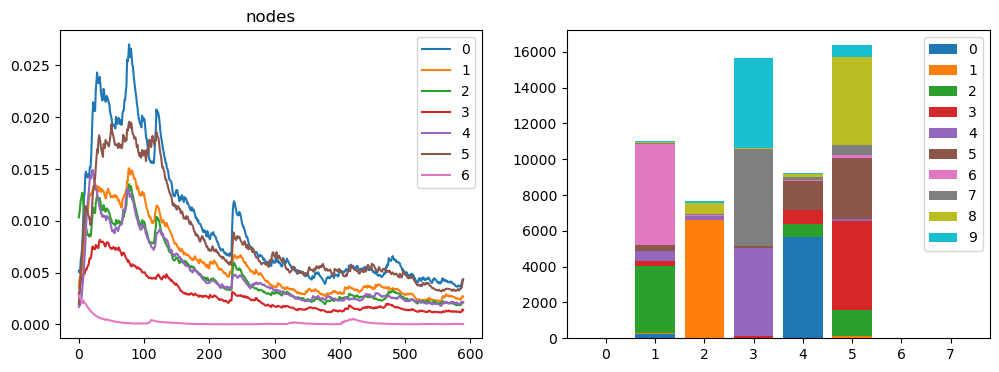

In [30]:
model = GeneralMoE(GateFFF(in_dim, depth, tree_act=nn.Identity()), 
                   SoftMergingExperts(2**depth, in_dim, out_dim, h_dim, save_probs=True))
model = torch.compile(model)
cbs = [ProbsDistrCB(module=model.experts), GetGradCB([model.gate.nodes]), ShowGraphCallback()]
Learner(dls, model, loss_func=F.cross_entropy, metrics=accuracy, cbs=cbs).fit_one_cycle(5, lr_max=1e-2)
summary()

epoch,train_loss,valid_loss,accuracy,time
0,0.556834,0.500601,0.864100,00:21
1,0.291927,0.286505,0.924900,00:15
2,0.217656,0.266783,0.927600,00:17
3,0.166090,0.232335,0.938500,00:17
4,0.140142,0.227093,0.939600,00:17


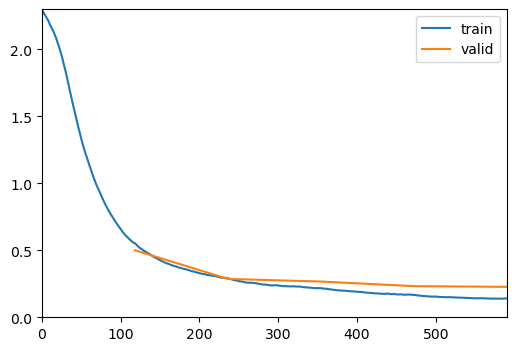

In [43]:
model = GeneralMoE(GateMoE(in_dim, 2**depth), 
                   SoftMergingExperts(2**depth, in_dim, out_dim, h_dim, save_probs=True))
model = torch.compile(model)
cbs = [ProbsDistrCB(module=model.experts), ShowGraphCallback()]
Learner(dls, model, loss_func=F.cross_entropy, metrics=accuracy, cbs=cbs).fit_one_cycle(5, lr_max=1e-2)

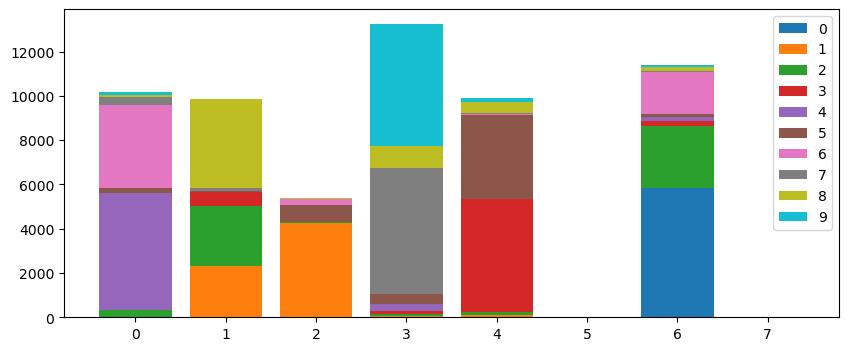

In [48]:
cbs[0].show(-1, figsize=(10,4))